# Exploring Factor Attribution of a Fund

I wanted to explore the factor attribtution of a mutual fund, hedge fund, ETF, you name it, based on the easily replicated Fama French (FF) Factors such as Value, Momentum, Size, etc. It is very easy for a fund manager to claim alpha, but after regressing the factors of value and momentum their alpha more no longer be statistically significant.

In [33]:
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web
import pandas as pd
from datetime import datetime
from sklearn import linear_model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib import style

%matplotlib inline

pd.set_option('display.max_columns',40)

Below are the available datasets to choose from in the Kenneth French database but we will only need 2

In [34]:
len(get_available_datasets())

295

In [35]:
#Set the date range for the portfolio/fund you want to analyze
start=datetime(2000, 1, 1)
end=datetime(2019, 8, 31)

#pick the fund, etf, or portfolio you want to measure vs. factors. In this case I chose Berkshire Hathaway Class A.
FUND = web.DataReader("BRK-A", "av-daily-adjusted", start, end, access_key = 'APIKEYHERE') 

You will need to get the 'file name' from the the actual url via the French
website, below is the dataset from the Daily FF factors (size, value, market) and momentum for US equities.

In [36]:
ds = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start = start)
                    
ds_mom = web.DataReader('F-F_Momentum_Factor_daily', 'famafrench', start = start)
        
print(ds['DESCR'])
print(ds_mom['DESCR'])
#below is a simple description of both datasets

F-F Research Data Factors daily
-------------------------------

This file was created by CMPT_ME_BEME_RETS_DAILY using the 201909 CRSP database. The Tbill return is the simple daily rate that, over the number of trading days in the month, compounds to 1-month TBill rate from Ibbotson and Associates Inc. Copyright 2019 Kenneth R. French

  0 : (4967 rows x 4 cols)
F-F Momentum Factor daily
-------------------------

This file was created by CMPT_ME_PRIOR_RETS_DAILY using the 201909 CRSP database. It contains a momentum factor, constructed from six value-weight portfolios formed using independent sorts on size and prior return of NYSE, AMEX, and NASDAQ stocks. MOM is the average of the returns on two (big and small) high prior return portfolios minus the average of the returns on two low prior return portfolios. The portfolios are constructed daily. Big means a firm is above the median market cap on the NYSE at the end of the previous day; small firms are below the median NYSE market ca

In [37]:
#this is what the first 5 rows of the dataset look like, which is the daily factor returns
ds[0].head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2000-01-03,-0.71,0.38,-0.85,0.021
2000-01-04,-4.06,-0.04,2.21,0.021
2000-01-05,-0.09,0.18,0.14,0.021
2000-01-06,-0.73,-0.67,1.38,0.021
2000-01-07,3.21,-0.59,-1.24,0.021


We will need to store the data in a new dataframe and convert to decimal form to have correct return calculations

In [38]:
data = ds[0]
data = data/100

data_mom = ds_mom[0]
data_mom = data_mom/100

In [39]:
data_mom = data_mom.rename(columns={'Mom   ':'Mom'}) #I had to remove the extra white space in the title

#combine the two dataframes
data_df = pd.DataFrame()
data_df = data.join(data_mom)                                  

#calculate the returns of the choosen fund
fund = pd.DataFrame()
fund['fund returns'] = FUND['adjusted close'].pct_change()

#join the FF dataframes with the fund dataframe
df = pd.DataFrame()
df = data_df.join(fund)
df.dropna(inplace=True)
df.head()
df.columns

X = df[['Mkt-RF','SMB','HML','Mom','RF']] # here we have 5 variables for multiple regression. 
Y = df['fund returns']
 

## Linear Regression for Factor Attribution

We want to regress the different factors against the performance of the fund to see how much is explained by easily replicated investment factors and how much is unexplainable alpha.

In [40]:
#####Stats package and large output#####
X = df[['Mkt-RF','SMB','HML','Mom']] # here we have 5 variables for multiple regression. 
Y = df['fund returns']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.params
results.tvalues
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           fund returns   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     576.3
Date:                Mon, 11 Nov 2019   Prob (F-statistic):               0.00
Time:                        09:48:35   Log-Likelihood:                 15027.
No. Observations:                4946   AIC:                        -3.004e+04
Df Residuals:                    4941   BIC:                        -3.001e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.552      0.1

/anaconda3/envs/myenv1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


We can look at the P values of the coefficients to see if they are statistially significant than zero. With BRK-A we see that the Market Equity Risk premium, Size effect (SMB), and Value factor (HML) are siginficant at the 1% level but the Momentum is not. Moreover, the adjusted R-squared is .318 meaning 31.8% of the BRK-A's returns can be explained by the model. We will see the same but simpler output below

In [41]:
########### with sklearn############
X = df[['Mkt-RF','SMB','HML','Mom']] # here we have 3 variables for multiple regression. 
Y = df['fund returns']

regr = linear_model.LinearRegression()
regr.fit(X, Y)
regr.score(X, Y)

print('Mkt-RF, SMB, HML, Mom Beta Coefficient : \n', regr.coef_)
print(regr.intercept_)

unexplained_variation = round(1 - round(regr.score(X, Y),3),3)

#Adjusted R Squared below which is nearly the same
adjusted_R_Squared = round((1 - (1-regr.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)),3)

#amound explained and unexplained by index etfs
print('The factors explain ' + str(adjusted_R_Squared) + ' percent of the portfolio variation' + 
      ' and thus ' + str(unexplained_variation) + ' is unexplained by the factors')

Mkt-RF, SMB, HML, Mom Beta Coefficient : 
 [ 0.61388725 -0.09272603  0.41146868  0.02814096]
0.00025624127277150736
The factors explain 0.318 percent of the portfolio variation and thus 0.682 is unexplained by the factors


Let's look at the annualized returns for the factors and fund for the time frame

In [42]:
annualized_returns = (1+df).cumprod()**(252/len(df))-1
annualized_returns[-1:]

,Mkt-RF,SMB,HML,RF,Mom,fund returns
Date,,,,,,
2019-08-30,0.042246,0.017718,0.022485,0.016284,0.028319,0.09105


In [43]:
returns = []
returns = np.array(annualized_returns.iloc[-1:,[0,1,2,4]])
returns

array([[0.04224574, 0.01771784, 0.0224852 , 0.02831864]])

In [44]:
betas = pd.DataFrame()
betas['coeff'] = regr.coef_
betas['perf'] = returns.transpose()
betas['return contribution'] = betas['coeff']*betas['perf']

In [45]:
fund_returns = annualized_returns.iloc[-1,-1]
fund_returns_exess = fund_returns - annualized_returns.iloc[-1,-3] #remove the risk-free return to get excess return
alpha = fund_returns_exess - betas['return contribution'].sum()

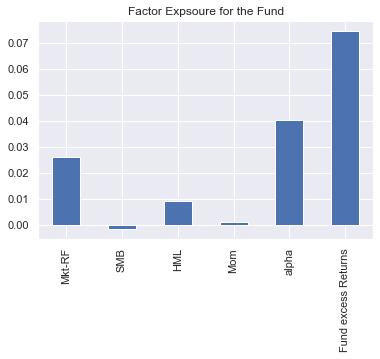

In [46]:
betas.rename({0: 'Mkt-RF', 1: 'SMB', 2: 'HML', 3: 'Mom'})
totals = pd.DataFrame()
totals = betas['return contribution']

alpha_df = pd.DataFrame()
alpha_df = alpha
alpha_df = pd.Series(alpha_df)
totals = totals.append(alpha_df)
fund_returns_excess_df = pd.Series(fund_returns_exess)
totals = totals.append(fund_returns_excess_df)
totals = totals.reset_index(drop=True)
totals = totals.rename({0: 'Mkt-RF', 1: 'SMB', 2: 'HML',3: 'Mom', 4: 'alpha', 5: 'Fund excess Returns'})

#Plots the factor attribution of the portfolio
sns.set()
plt.title("Factor Expsoure for the Fund")
totals.T.plot(kind='bar', stacked=True)

So we can see that Berkshire Hathaway since 2000 has created about 4% of alpha annually beyond what can be reproduced by factors. For further research and analysis, including a quality factor and low volatility factor could potentially bring the alpha near to zero in light of Buffet's proclaimed investment strategy